In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.manifold import TSNE
import requests

# Load dataset from URL
def load_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        text = response.text
    else:
        raise Exception(f"Failed to load data, status code: {response.status_code}")
    return text

# Clean text
def clean_text(text):
    # Remove hyperlinks (http, https, and www)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub('[^a-zA-Z0-9 \.]', '', text)  # Remove special characters
    text = text.lower()
    return text

# Prepare data
url = "https://www.gutenberg.org/files/1661/1661-0.txt"
text = load_data(url)
cleaned_text = clean_text(text)
words = cleaned_text.split()

# Create vocabulary
unique_words = sorted(set(words))
stoi = {s: i + 1 for i, s in enumerate(unique_words)}  # String to index
itos = {i: s for s, i in stoi.items()}  # Index to string

print(f"Vocabulary Size: {len(stoi)}")

Vocabulary Size: 16813


In [2]:
import torch
torch.cuda.is_available()  # Returns True if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('done')

done


In [3]:
block_size = 15  # Number of words to predict the next one
X, Y = [], []

for i in range(len(words) - block_size):
    context = words[i:i + block_size]  # Get the context of words
    next_word = words[i + block_size]  # Get the next word
    X.append([stoi[w] for w in context])  # Append the context as indices
    Y.append(stoi[next_word])  # Append the next word index

# Convert to tensors
X = torch.tensor(X)
Y = torch.tensor(Y)

# Print the input-output pairs
for i in range(len(X)):
    context_words = [itos[idx.item()] for idx in X[i]]  # Convert indices back to words
    next_word = itos[Y[i].item()]  # Convert index to word
    print(f" {' '.join(context_words)} --->  {next_word}")
print('done')

 the project gutenberg ebook of the adventures of sherlock holmesby arthur conan doylethis ebook is --->  for
 project gutenberg ebook of the adventures of sherlock holmesby arthur conan doylethis ebook is for --->  the
 gutenberg ebook of the adventures of sherlock holmesby arthur conan doylethis ebook is for the --->  use
 ebook of the adventures of sherlock holmesby arthur conan doylethis ebook is for the use --->  of
 of the adventures of sherlock holmesby arthur conan doylethis ebook is for the use of --->  anyone
 the adventures of sherlock holmesby arthur conan doylethis ebook is for the use of anyone --->  anywhere
 adventures of sherlock holmesby arthur conan doylethis ebook is for the use of anyone anywhere --->  in
 of sherlock holmesby arthur conan doylethis ebook is for the use of anyone anywhere in --->  the
 sherlock holmesby arthur conan doylethis ebook is for the use of anyone anywhere in the --->  united
 holmesby arthur conan doylethis ebook is for the use of anyone 

In [4]:
class NextWordMLP(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_size):
        super(NextWordMLP, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)  # Flatten the input
        x = F.tanh(self.lin1(x))
        x = self.lin2(x)
        return x

# Initialize model
model_tanh_32_15 = NextWordMLP(len(stoi) + 1, emb_dim=32, hidden_size=1024).to(device)
print('done')

done


In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Select a subset of words (for example, 100 words)
selected_words = [
    "detect", "discover", "hide", "expose", "appear", "vanish",
    "observe", "notice", "truth", "lie", "crime", "justice",
    "clue", "evidence", "suspect", "accuse", "mystery", "solution",
    "search", "find", "silent", "speak", "solve", "unravel",
    "conceal", "reveal", "doubt", "certainty", "question", "answer",
    "sherlock", "watson", "holmes", "baker", "london", "night",
    "door", "case", "strange", "letter", "fear", "mind",
    "fact", "story", "secret", "danger", "friend", "enemy",
    "plan", "proof"
]  # Add more as needed
selected_indices = [stoi[word] for word in selected_words if word in stoi]

# Step 2: Get embeddings before training
with torch.no_grad():
    model_tanh_32_15.eval()
    embeddings_before = model_tanh_32_15.emb(torch.tensor(selected_indices).to(device)).cpu().numpy()
print('done')

done


In [6]:
torch.cuda.empty_cache()
print('done')

done


In [7]:
import torch
import torch.nn as nn
import time

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
emb_dim = 32  # Embedding dimension for words
hidden_size = 1024  # Size of hidden layer
block_size = 15 # Context length (number of words to predict the next one)
vocab_size = len(stoi)  # Size of the vocabulary
batch_size = 1500
print_every = 1
elapsed_time = []

# Initialize model, loss function, and optimizer
model = NextWordMLP(vocab_size + 1, emb_dim=emb_dim, hidden_size=hidden_size).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)

# Move data to the GPU
X = X.to(device)
Y = Y.to(device)

# Training loop
for epoch in range(800):  # Loop for specified epochs
    
    model.train()  # Set model to training mode

    # Mini-batch processing
    for i in range(0, X.shape[0], batch_size):
        x_batch = X[i:i + batch_size].to(device)  # Get the batch of input sequences
        y_batch = Y[i:i + batch_size].to(device)  # Get the batch of next word labels

        # Forward pass: predict the next word
        y_pred = model(x_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Clear previous gradients
        opt.zero_grad()

        # Backpropagation: compute gradients
        loss.backward()

        # Update model parameters using optimizer
        opt.step()


#     # Print loss at intervals
#     if epoch % print_every == 0:
    print(f"Epoch {epoch}, Loss: {loss.item()}")

print("Training complete")

Epoch 0, Loss: 10.74581241607666
Epoch 1, Loss: 1.6906704902648926
Epoch 2, Loss: 0.9764758348464966
Epoch 3, Loss: 0.5215696096420288
Epoch 4, Loss: 0.20103760063648224
Epoch 5, Loss: 0.0692804604768753
Epoch 6, Loss: 0.045479901134967804
Epoch 7, Loss: 0.039029914885759354
Epoch 8, Loss: 0.02362062595784664
Epoch 9, Loss: 0.010119430720806122
Epoch 10, Loss: 0.004771339241415262
Epoch 11, Loss: 0.0017116679809987545
Epoch 12, Loss: 0.0027825890574604273
Epoch 13, Loss: 0.00046955791185609996
Epoch 14, Loss: 0.0004191874759271741
Epoch 15, Loss: 0.00037432636599987745
Epoch 16, Loss: 0.000370458175893873
Epoch 17, Loss: 0.0003338070528116077
Epoch 18, Loss: 0.0003136892046313733
Epoch 19, Loss: 0.00029901956440880895
Epoch 20, Loss: 0.0002911396441049874
Epoch 21, Loss: 0.0002832568425219506
Epoch 22, Loss: 0.0002797500928863883
Epoch 23, Loss: 0.0002748973201960325
Epoch 24, Loss: 0.0002735497255343944
Epoch 25, Loss: 0.0002703936770558357
Epoch 26, Loss: 0.00027045869501307607
Epoch

In [8]:
torch.save(model.state_dict(), 'model_tanh_32_15.pth')
print('done')

done


In [9]:
with torch.no_grad():
    embeddings_after = model.emb(torch.tensor(selected_indices).to(device)).cpu().numpy()
print('done')

done


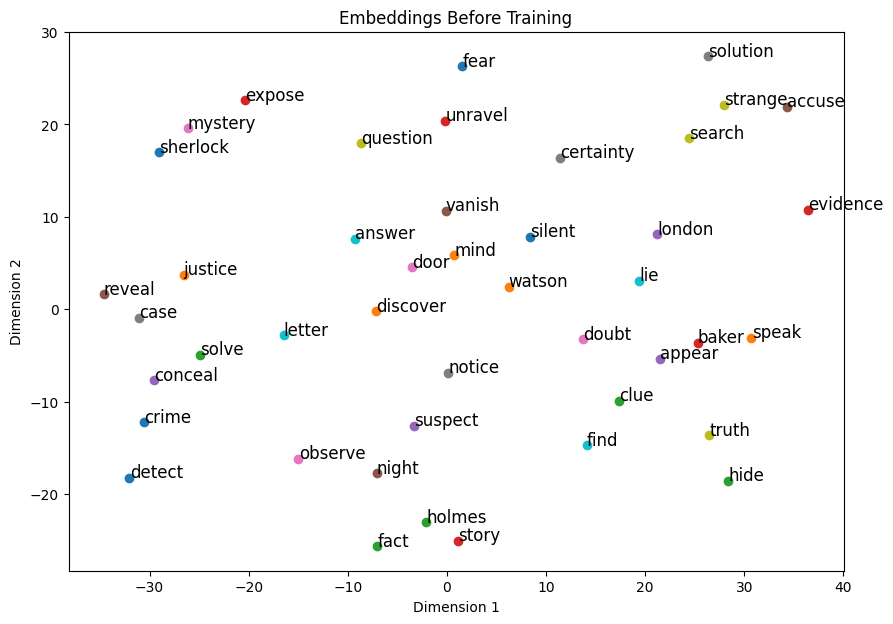

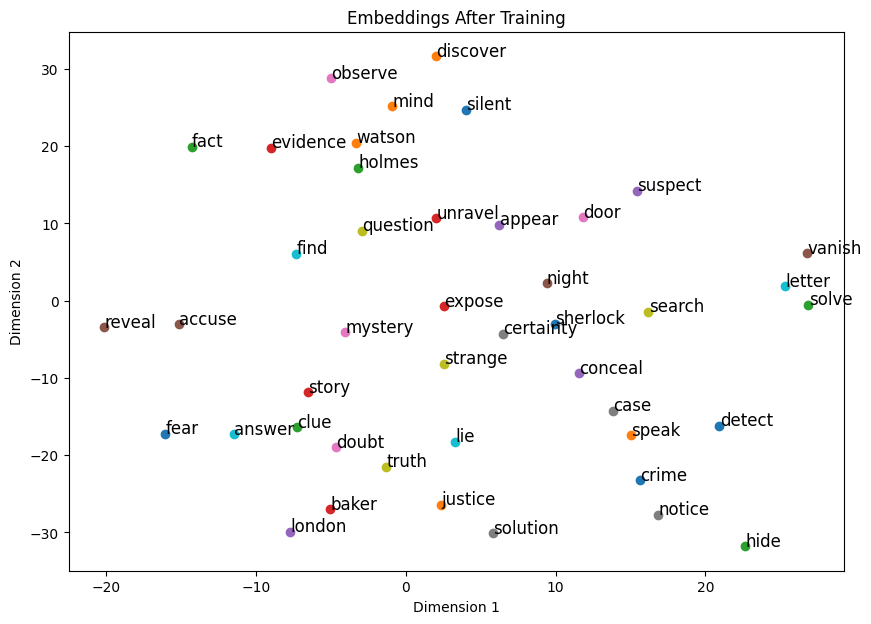

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Sample size and TSNE perplexity adjustment
sample_size = len(embeddings_before)
perplexity = min(5, sample_size - 1)  # Set a smaller perplexity if needed

# Initialize t-SNE with the adjusted perplexity and n_components=2
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
embeddings_before_2d = tsne.fit_transform(embeddings_before)
embeddings_after_2d = tsne.fit_transform(embeddings_after)

# Ensure selected_words and embeddings_before_2d have the same length
min_length = min(len(selected_words), len(embeddings_before_2d))
selected_words = selected_words[:min_length]
embeddings_before_2d = embeddings_before_2d[:min_length]
embeddings_after_2d = embeddings_after_2d[:min_length]

# Plot function for embeddings
def plot_embeddings(embeddings, words, title):
    plt.figure(figsize=(10, 7))
    for i, word in enumerate(words):
        try:
            x, y = embeddings[i]  # Ensure embeddings[i] has only 2 values
            plt.scatter(x, y)
            plt.text(x + 0.02, y + 0.02, word, fontsize=12)
        except ValueError:
            print(f"Skipping embedding at index {i} due to incorrect dimensions: {embeddings[i]}")
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

# Plot before training
plot_embeddings(embeddings_before_2d, selected_words, "Embeddings Before Training")

# Plot after training
plot_embeddings(embeddings_after_2d, selected_words, "Embeddings After Training")